In [16]:
%%capture
#tensorflow_version 1.4.0
#!pip install h5py==2.10.0 --force-reinstall

#@title ## D4N4 Image Recognition Notebook
#@markdown This Colab Notebook is a demonstration of our Image Recognition approach for the Corpus Nummorum dataset based on a VGG16 model.
#@markdown You can upload your own coin images for a prediction of our model or use several sample images provided by us.
#@markdown The first step is to open the "Runtime" dropdown menu above and then click "Execute all". Alternatively, you can press "Ctrl+F9" on your keyboard
#@markdown or you can click the small arrows in a white circle on the left side of every cell. The execution of all cells can take some
#@markdown time due to the availability of Colab resources and the download of our models to the temporary Colab storage.
#@markdown A small green check mark on the left shows the sucessful execution of a cell. You can take a look at the program code by clicking
#@markdown the "Show Code" button under this text. Double-clicking on this text closes the code cell again.

from IPython.display import clear_output
import ipywidgets as widgets
from IPython.display import display
clear_output()

import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=DeprecationWarning)

import tensorflow as tf
from tensorflow import keras
# Enables tensorflow operations without running a graph
#tf.enable_eager_execution()

import os
import numpy as np
import shutil

from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.image as mpim
import matplotlib.gridspec as gridspec
import ast
import math
import skimage.transform

from PIL import Image
import requests
from io import BytesIO
from bs4 import BeautifulSoup
import cv2

tf.get_logger().setLevel('ERROR')

if not os.path.exists("vgg16-2/"):
  os.mkdir("vgg16-2")
  !wget -O vgg16_types.zip 'https://docs.google.com/uc?export=download&id=1TS4a4Jaw4e9ZhOPBBuxhBcKXvHHIE6lA&confirm=t'
  !unzip vgg16_types.zip
  !wget -O vgg16_mints.zip 'https://docs.google.com/uc?export=download&id=1tW3X2HV3_2ulKolgrFl9FLmPHeq7g0hB&confirm=t'
  !unzip vgg16_mints.zip
  !wget -O dict_types_77.txt 'https://docs.google.com/uc?export=download&id=1vPIR075iPh70TxvvtfbhQOVUfW3EExsA&confirm=t'
  !wget -O dict_mints_78.txt 'https://docs.google.com/uc?export=download&id=1SI4k47aBqPugbXxTw5__RQOzGg0uNkvg&confirm=t'
  # old modells
  #!wget -O vgg16_types 'https://docs.google.com/uc?export=download&id=1Q0zGHZUA5LxKOqy91F2SFFej44juqb4A&confirm=t'
  #!wget -O vgg16_mints 'https://docs.google.com/uc?export=download&id=1G_7wz3QmRCygGfxpoqBNAuX1gS2mZbQU&confirm=t'
  # old lists (fewer classes)
  #!wget -O dict_types.txt 'https://docs.google.com/uc?export=download&id=1qzs_b-99_4COkmIYXXBLqOft1JXTcicj&confirm=t'
  #!wget -O dict_mints.txt 'https://docs.google.com/uc?export=download&id=1ERVh9hV80rBQZu1Xg9B_HQVP7GIbgz11&confirm=t'
  !wget -O Type_513_obv.jpg 'https://docs.google.com/uc?export=download&id=1i-w5YhaNHwTEPlG-SvuJZ1D_WsXDLayi&confirm=t'
  !wget -O Type_513_rev.jpg 'https://docs.google.com/uc?export=download&id=1YZS1S3teO6mpQXR1G-snQg0afarnwG7F&confirm=t'
  !wget -O Type_8862_obv.jpg 'https://docs.google.com/uc?export=download&id=1ki1XpRYX9bfsFclDjZAwUK_Xo7v_XNgu&confirm=t'
  !wget -O Type_8862_rev.jpg 'https://docs.google.com/uc?export=download&id=1MZ0Z0Bt9PlXmKA35rC17C6cMsryva7E0&confirm=t'


if not os.path.exists("temp_storage/"):
  os.mkdir("temp_storage")
  os.mkdir("temp_storage/obv")
  os.mkdir("temp_storage/rev")

obv_storage = "temp_storage/obv/"
rev_storage = "temp_storage/rev/"
last_conv_layer_name = "block5_conv3"

shutil.copy('Type_513_obv.jpg', 'temp_storage/obv/Type_513.jpg')
shutil.copy('Type_513_rev.jpg', 'temp_storage/rev/Type_513.jpg')
shutil.copy('Type_8862_rev.jpg', 'temp_storage/rev/Type_8862.jpg')
shutil.copy('Type_8862_obv.jpg', 'temp_storage/obv/Type_8862.jpg')


model1 = tf.keras.models.load_model('vgg16_types_77')
model2 = tf.keras.models.load_model('vgg16_mints_78')

with open('dict_types_77.txt') as f:
    types = f.read()
    dict_types = d = ast.literal_eval(types)

with open('dict_mints_78.txt') as f:
    mints = f.read()
    dict_mints = d = ast.literal_eval(mints)

image_size = (224,224)
last_conv_layer_name = "block5_conv3"


def pull_images_by_id(type_id):
    # searches matching images for every type prediction
    src = "https://www.corpus-nummorum.eu/types/" + str(type_id)

    # search images

    result = requests.get(src)

    # check if url call was successful
    if result.status_code == 404:
        print("Type not yet published")
        return
    else:
        if result.status_code == 200:
            soup =  BeautifulSoup(result.content, "html.parser")
        else:
            return "Connection Failed"

    # search links
        try:
            thumb_0 = soup.find('div',{"id":"thumb-0"}).find('img',{"id":"{coin-thumbnail-0"})["src"]
            thumb_1 = soup.find('div',{"id":"thumb-1"}).find('img',{"id":"{coin-thumbnail-1"})["src"]

            # pull images
            response_0 = requests.get(thumb_0)
            response_1 = requests.get(thumb_1)

            img_0 = Image.open(BytesIO(response_0.content))
            img_1 = Image.open(BytesIO(response_1.content))

            return img_0, img_1
        except:
            return "Error"

def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (224, 224, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 224, 224, 3)
    array = np.expand_dims(array, axis=0)
    return array

def top_5(preds):
    # Find the top-5 predictions
    top_5 = np.argsort(preds) # sorts indices according to their probability
    top_5 = top_5[0]
    top_5 = top_5[::-1] # we want the top-5 probabilities at the first 5 entries
    top_5 = top_5[0:5]
    probs = []
    top_5_new = []
    for item in top_5:
      if preds[0][item] > 0:
        probs.append(preds[0][item])
        top_5_new.append(item)
    return top_5_new, probs

def translate(top5, classes):
    # Translates the numerical representation of classes to their respective names
    outcome = []
    if classes == "types":
      for key in top5:
        outcome.append(dict_types[key])
    if classes == "mints":
      for key in top5:
        outcome.append(dict_mints[key])
    return outcome

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Makes the GradCam Heatmap (new version)
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        #print(last_conv_layer_output)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    #print(grads)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    #print(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def combine_image_heatmap(img_path, heatmap):
  # Combines the created heatmap and the source image
  try:
    img2 = keras.preprocessing.image.load_img(img_path)
    img2 = keras.preprocessing.image.img_to_array(img2)
    #img2 = np.fliplr(img2)
    # We rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # We use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # We use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # We create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img2.shape[1], img2.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.3 + img2
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
  except Exception as e:
    print(e)
  return superimposed_img

# define a function for horizontally concatenating images of different heights
# Source: https://www.geeksforgeeks.org/concatenate-images-using-opencv-in-python/
def hconcat_resize(img_list,
                   interpolation
                   = cv2.INTER_CUBIC):
      # take minimum hights
    h_min = min(img.shape[0]
                for img in img_list)

    # image resizing
    im_list_resize = [cv2.resize(img,
                       (int(img.shape[1] * h_min / img.shape[0]),
                        h_min), interpolation
                                 = interpolation)
                      for img in img_list]

    # return final image
    return cv2.hconcat(im_list_resize)

# resize the images to a square with padding
# Source: https://gist.github.com/CMCDragonkai/cf25ad969e3a7fc1e48d60ecf20a2253

# you use this just before passing any image to a CNN
# which usually expects square images
# however your input images can be of variable size
# you don't want to just squash the images to a square
# because you will lose valuable aspect ratio information
# you want to resize while preserving the aspect ratio
# these 2 functions perform this resizing behaviour
# images are assumed to be formatted as Height, Width, Channels
# we will use bound_image_dim to first bound the image to a range
# the smallest dimension will be scaled up to the min_size
# the largest dimension will be scaled down to the max_size
# then afterwards you square_pad_image to pad the image to a square
# filling the empty space with zeros

def bound_image_dim(image, min_size=None, max_size=None):
    if (max_size is not None) and \
       (min_size is not None) and \
       (max_size < min_size):
        raise ValueError('`max_size` must be >= to `min_size`')
    dtype = image.dtype
    (height, width, *_) = image.shape
    # scale the same for both height and width for fixed aspect ratio resize
    scale = 1
    # bound the smallest dimension to the min_size
    if min_size is not None:
        image_min = min(height, width)
        scale = max(1, min_size / image_min)
    # next, bound the largest dimension to the max_size
    # this must be done after bounding to the min_size
    if max_size is not None:
        image_max = max(height, width)
        if round(image_max * scale) > max_size:
            scale = max_size / image_max
    if scale != 1:
        image = skimage.transform.resize(
            image, (round(height * scale), round(width * scale)),
            order=1,
            mode='constant',
            preserve_range=True)
    return image.astype(dtype), image_max


def square_pad_image(image, size):
    (height, width, *_) = image.shape
    if (size < height) or (size < width):
        raise ValueError('`size` must be >= to image height and image width')
    pad_height = (size - height) / 2
    pad_top = math.floor(pad_height)
    pad_bot = math.ceil(pad_height)
    pad_width = (size - width) / 2
    pad_left = math.floor(pad_width)
    pad_right = math.ceil(pad_width)
    return np.pad(
        image, ((pad_top, pad_bot), (pad_left, pad_right), (0, 0)),
        mode='constant')

def plot_types(type_list, probs, img, source_obv, source_rev):
    # Plot all images (source and predictes types)
    source = mpim.imread(img)
    fig = plt.figure(figsize=(6, 3.75))
    print()
    plt.imshow(source)
    plt.axis('off')
    plt.title("Combined source image")
    plt.show()
    print()
    print("Predictions:")
    print()
    i = 0
    source_obv = mpim.imread(source_obv)
    source_rev = mpim.imread(source_rev)

    for item in type_list:
      i += 1
      print(str(i) + ". TypeId: " + str(item)  + ", Probability: " + str(probs[i-1]))
      print("Link to type: https://www.corpus-nummorum.eu/types/"+ item)
      try:
        obv, rev = pull_images_by_id(item)
        rows = 1

        if i < 8:
          fig = plt.figure(figsize=(6, 3.75), constrained_layout=True)
          spec = gridspec.GridSpec(ncols=4, nrows=1, figure=fig)
          columns = 4
          #source_obv = mpim.imread(source_obv)
          #source_rev = mpim.imread(source_rev)
          # showing obverse image
          fig.add_subplot(spec[0, 0])
          plt.imshow(obv)
          plt.axis('off')
          plt.title("Obverse")

          # showing reverse image
          fig.add_subplot(spec[0, 1])
          plt.imshow(rev)
          plt.axis('off')
          plt.title("Reverse")

          # showing source image
          fig.add_subplot(spec[0, 2])
          plt.imshow(source_obv)
          plt.axis('off')
          plt.title("Source Obverse")

          fig.add_subplot(spec[0, 3])
          plt.imshow(source_rev)
          plt.axis('off')
          plt.title("Source Reverse")

          plt.show()

        else:
          columns = 2
          fig = plt.figure(figsize=(4, 2.75))
          # showing obverse image
          fig.add_subplot(rows, columns, 1)
          plt.imshow(obv)
          plt.axis('off')
          plt.title("Obverse")

          # showing reverse image
          fig.add_subplot(rows, columns, 2)
          plt.imshow(rev)
          plt.axis('off')
          plt.title("Reverse")
          plt.show()

        plt.show()
      except Exception as e:
        print()

def combine_images(img_obv, img_rev):
    # Concatenate obverse and reverse images and convert it to quadratic format
    # with horizontal paddings
    img_obverse = cv2.imread(img_obv)
    img_reverse = cv2.imread(img_rev)
    img_list = [img_obverse, img_reverse]
    if img_obverse.shape[0] != img_reverse.shape[0]:
        img_type = hconcat_resize(img_list)

    else:
        img_type = cv2.hconcat(img_list)
    (height, width, *_) = img_type.shape
    max_size = max(height, width)
    min_size = min(height, width)
    new_img, max_size = bound_image_dim(img_type, min_size, max_size)
    new_img = square_pad_image(new_img, max_size)
    cv2.imwrite("combined_image.jpg", new_img)
    return "combined_image.jpg"


def predict_type(img_path_obv, img_path_rev, model=model1):
  # Predicts an image with the type model
  try:
    print("Process has started.")
    img_path = combine_images(img_path_obv, img_path_rev)
    img_size = (224, 224)
    preprocess_input = keras.applications.resnet.preprocess_input
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    preds = model.predict(img_array)
    out, prob = top_5(preds)
    out = translate(out, "types")
    plot_types(out, prob, img_path, img_path_obv, img_path_rev)
    model.layers[-1].activation = None
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    final_image = combine_image_heatmap(img_path, heatmap)
    print()
    plt.title("GradCam heatmap")
    plt.imshow(final_image)
    plt.axis('off')
    plt.show()

    print("Process has ended.")
    print()
  except Exception as e:
    print(e)


def predict_mint(img_path_obv, img_path_rev, model=model2):
   # Predicts an image with the mint model
  try:
    print("Process has started.")
    img_path = combine_images(img_path_obv, img_path_rev)
    img_size = (224, 224)
    preprocess_input = keras.applications.resnet.preprocess_input
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    preds = model.predict(img_array)
    out, prob = top_5(preds)
    out = translate(out, "mints")
    i = 0
    source = mpim.imread(img_path)
    fig = plt.figure(figsize=(5, 3.25))
    print()
    plt.title("Combined source image")
    plt.imshow(source)
    plt.axis('off')
    plt.show()
    print()
    print("Predictions:")
    print()
    for item in out:
      i += 1
      new_item = item.replace(' ','+')
      print(str(i) + ". Mint: " + str(item)  + ", Probability: " + str(prob[i-1]))
      print("Link to mint: https://www.corpus-nummorum.eu/search/types?type=quicksearch&q="+ new_item)
    #gradcam, preds = plot_cam(img_path, model)
    #print("Most likely result: https://www.corpus-nummorum.eu/search/types?type=quicksearch&q=" +out[0])
    model.layers[-1].activation = None
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    final_image = combine_image_heatmap(img_path, heatmap)
    print()
    plt.title("GradCam heatmap")
    plt.imshow(final_image)
    plt.axis('off')
    plt.show()

    print("Process has ended.")
    print()
  except Exception as e:
    print(e)



Button(description='Upload', style=ButtonStyle())

Output()

Button(description='Delete uploaded files', style=ButtonStyle())

Button(description='Delete Session', style=ButtonStyle())

Button(description='Predict Type', style=ButtonStyle())

Button(description='Predict Mint', style=ButtonStyle())

Process has started.
1/1 [==============================] - 0s 150ms/step



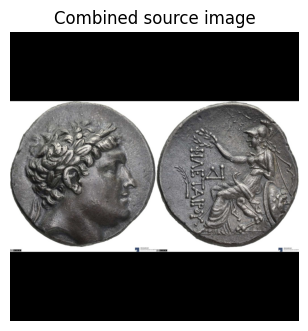


Predictions:

1. TypeId: 8461, Probability: 1.0
Link to type: https://www.corpus-nummorum.eu/types/8461


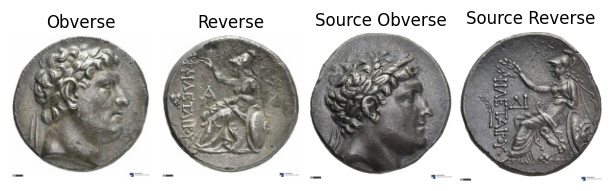

2. TypeId: 8455, Probability: 5.2900244e-34
Link to type: https://www.corpus-nummorum.eu/types/8455


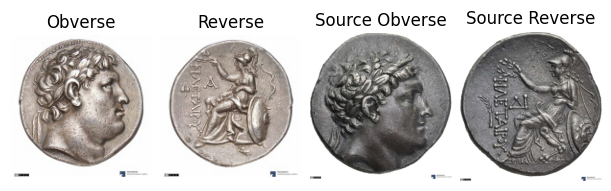

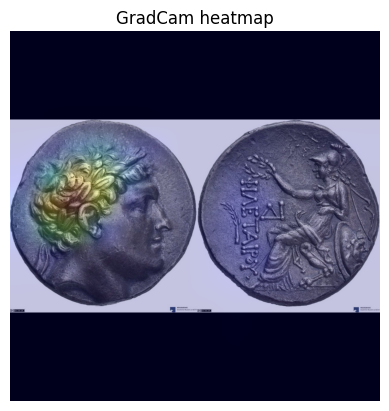

Process has ended.



In [15]:
#@title ## How to use the Image Recognition
#@markdown After both code cells were executed, you can use the model to predict coin types and mints on your images.
#@markdown For this you can upload your own coin images. Since the model is only trained for CN coins, it is recommended to use only coin photos of the ancient landscapes treated there.
#@markdown You can get coin images from www.corpus-nummorum.eu. Alternatively, we provide one coin from our test set (Type_513) and one which was not trained (Type_8862) here.

#@markdown If you want to use your own images, you can choose obverse and reverse of a coin separate with the "Select Obverse/Reverse" button from your local drive. Afterwards, you have to click the "Upload" Button.
#@markdown You can also delete the uploaded files and the whole session with the respective button. The dropdown menus below contain the uploaded and the example images. You can combine the matching images, if you
#@markdown have uploaded several coins. For a prediction of a coin you must click the "Predict Type/Mint" buttons. "Predict Type" will show you up to
#@markdown five types which were predicted by our model.

#@markdown The first image shows you how your uploaded images were processed by our approach (called "Combined source image). Both images are concatenated and the brought into a
#@markdown quadratic format. After that, the results of the type prediction are shown in order of probability. You will get the CN Type ID, the respective probability of the prediction, a link to that type and
#@markdown a preview of that type in comparison to your image. Probabilities are given in decimal numbers. The higher the number, the more confident the model is. Despite a high probability, such a result can also be wrong.
#@markdown Values like "1.0" are the result of rounding processes during the execution of the prediction. Very small probabilities can occur as well, for example "5.965622e-10". This expression represents a
#@markdown number where you have to shift the decimal point ten positions to the left. If you click the "Predict Mint" button, you will get up to five results and their links for a coin image like in the type
#@markdown prediction. Because our mints have a lot of associated types there is no preview image for them. The last image is the GradCam heatmap. The GradCam approach shows the parts of the image which received
#@markdown the most attention from the model during the prediction process (yellow and red areas). In larger numbers, these heatmaps can help us identify the most important features of a class for the model.

#@markdown It should be noted that only 197 out of 19,600 types are currently trained in this model due to lack of training images. The mint prediction, on the other hand, includes 95 of 121 available mints of
#@markdown the CN dataset. The predicted mint results should be more accurate for most coins.
# If you want to provide us with feedback to this Colab notebook pls do something....


# Data
# data
#example_list = ["Type_513", "Type 8862"]

# Uploads
uploader_obv = widgets.FileUpload(
    description="Select Obverse",
    accept='',  # Accepted file extension e.g. '.txt', '.pdf', 'image/*', 'image/*,.pdf'
    multiple=True  # True to accept multiple files upload else False
)

uploader_rev = widgets.FileUpload(
    description="Select Reverse",
    accept='',  # Accepted file extension e.g. '.txt', '.pdf', 'image/*', 'image/*,.pdf'
    multiple=True  # True to accept multiple files upload else False
)

# Buttons and Dropdown Menus
ups = widgets.HBox([uploader_obv, uploader_rev])
button = widgets.Button(description="Upload")
buttond = widgets.Button(description="Delete uploaded files")
output = widgets.Output()
wordwidth= 500
buttoncnn_type = widgets.Button(description="Predict Type")
buttoncnn_mint = widgets.Button(description="Predict Mint")
buttonds = widgets.Button(description="Delete Session")
#buttoncnn_type_ex = widgets.Button(description="Predict Type on Example", layout = widgets.Layout(width = '180px'))
#buttoncnn_mint_ex = widgets.Button(description="Predict Mint on Example", layout = widgets.Layout(width = "180px"))
outputcnn = widgets.Output()

# Non editable fields
#test_example = widgets.HTML(
#    value="<b>Examples: </b>"
#)
obverse = widgets.HTML(
    value="<b>Obverse: </b>"
)
reverse = widgets.HTML(
    value="<b>Reverse: </b>"
)


# Dropdowns
drop_obv = widgets.Dropdown(
    options=os.listdir(obv_storage),
    disabled=False, continuous_update=True, layout={'width': 'max-content'}
)
drop_rev = widgets.Dropdown(
    options=os.listdir(rev_storage),
    disabled=False, continuous_update=True, layout={'width': 'max-content'}
)
#example_dropdown = widgets.Dropdown(
#    options=example_list,
#    disabled=False, continuous_update=True,layout={'width': 'max-content'},
#    value=None
#)

drops = widgets.HBox([obverse,drop_obv, reverse, drop_rev])
#drop_example =  widgets.HBox([test_example, example_dropdown])


# Functions
def predict_on_drop_type(b):
    predict_type(obv_storage+drop_obv.value, rev_storage+drop_rev.value)

def predict_on_drop_mint(b):
    predict_mint(obv_storage+drop_obv.value, rev_storage+drop_rev.value)

#def predict_on_drop_type_ex(b):
#    predict_type(Type_513_obv.jpg, Type_513_obv)

#def predict_on_drop_mint_ex(b):
#    predict_mint(obv_storage+drop_obv.value, rev_storage+drop_rev.value)

def on_button_clicked(b):

  for img in uploader_obv.value:
    uploaded_obv = uploader_obv.value[img]

    with open(obv_storage+img, "wb") as fp:
      fp.write(uploaded_obv['content'])

  for img in uploader_rev.value:
    uploaded_rev = uploader_rev.value[img]

    with open(rev_storage+img, "wb") as fp:
      fp.write(uploaded_rev['content'])

  if ".ipynb_checkpoints" in os.listdir(obv_storage):
    os.rmdir(obv_storage+".ipynb_checkpoints")

  if ".ipynb_checkpoints" in os.listdir(rev_storage):
    os.rmdir(rev_storage+".ipynb_checkpoints")


  drop_obv.options = os.listdir(obv_storage)
  drop_rev.options = os.listdir(rev_storage)
  uploader_obv.value.clear()
  uploader_obv._counter=0
  uploader_rev.value.clear()
  uploader_rev._counter=0

def delete_temp(b):
  for file in os.listdir(obv_storage):
    try:
      os.remove(obv_storage+file)
    except:
      pass
  for file in os.listdir(rev_storage):
    try:
      os.remove(rev_storage+file)
    except:
      pass

def delete_sess(b):
  clear_output()


# Display Buttons and Dropdown Menus
button.on_click(on_button_clicked)
buttond.on_click(delete_temp)
buttonds.on_click(delete_sess)
display(ups)
display(button, output)
display(buttond)
display(buttonds)
display(drops)
display(buttoncnn_type)
display(buttoncnn_mint)
buttoncnn_type.on_click(predict_on_drop_type)
buttoncnn_mint.on_click(predict_on_drop_mint)
#display(drop_example)
#display(buttoncnn_type_ex)
#display(buttoncnn_mint_ex)
#buttoncnn_type_ex.on_click(predict_on_drop_type_ex)
#buttoncnn_mint_ex.on_click(predict_on_drop_mint_ex)

